# Нейроинформатика. Лабораторная работа 4
### Сети с радиальными базисными элементами

Целью работы является исследование свойств некоторых видов сетей с радиальными базисными элементами, алгоритмов обучения, а также применение сетей в задачах классификации и аппроксимации функции.

Выполнил Моисеенков Илья, 408Б

In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Layer
from keras import backend as back

import matplotlib.pyplot as plt

## Задание 1

Попробуем использовать RBF сети для классификации линейно неразделимых классов

Подготовим датасет (с прошлой лабы)

In [ ]:
ellipse0 = dict(
    a = 0.2,
    b = 0.2,
    alpha = 0,
    x0 = -0.25,
    y0 = 0.25,
    label = 0,
)

ellipse1 = dict(
    a = 0.7,
    b = 0.5,
    alpha = -np.pi / 3,
    x0 = 0,
    y0 = 0,
    label = 1,
)

ellipse2 = dict(
    a = 1,
    b = 1,
    alpha = 0,
    x0 = 0,
    y0 = 0,
    label = 2,
)

In [ ]:
def gen_dataset(ellipses):
    t = np.linspace(0, 2 * np.pi, int(2 * np.pi / 0.025))
    
    points = np.array([
        [
            ellipses[i]['a'] * np.cos(t) * np.cos(ellipses[i]['alpha']) \
            - ellipses[i]['b'] * np.sin(t) * np.sin(ellipses[i]['alpha']) \
            + ellipses[i]['x0'],
         
            ellipses[i]['a'] * np.cos(t) * np.sin(ellipses[i]['alpha']) \
            + ellipses[i]['b'] * np.sin(t) * np.cos(ellipses[i]['alpha']) \
            + ellipses[i]['y0'],

            np.tile(ellipses[i]['label'], len(t)),
        
         ] for i in range(len(ellipses))])
    
    np.random.seed(0xDEAD)

    el_0 = points[0, :, np.random.choice(len(t), 60, replace=False)]
    el_1 = points[1, :, np.random.choice(len(t), 100, replace=False)]
    el_2 = points[2, :, np.random.choice(len(t), 120, replace=False)]
    
    data = np.vstack((el_0, el_1, el_2))
    np.random.shuffle(data)

    return data

In [ ]:
data1 = gen_dataset([ellipse0, ellipse1, ellipse2])

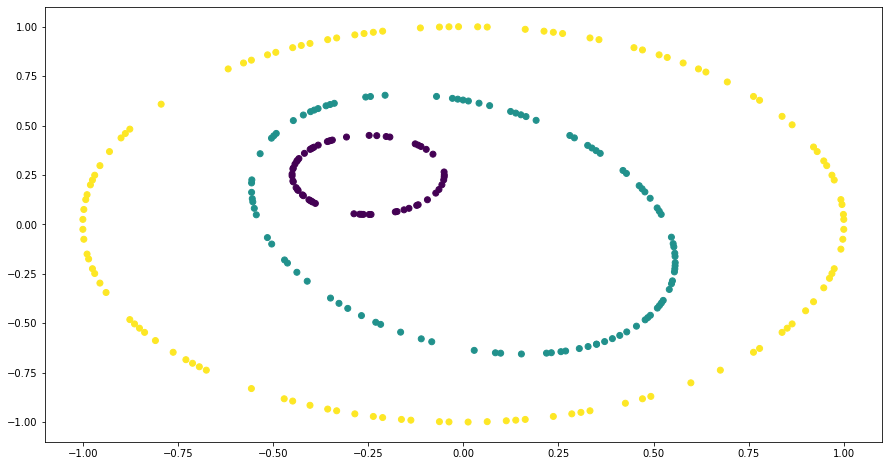

In [ ]:
plt.figure(figsize=(15, 8))

plt.scatter(data1[:, 0], data1[:, 1], c=data1[:, 2])

plt.show()

Поделим данные на трейн и вал

In [ ]:
train, val = np.split(data1, [int(.8*len(data1))])

In [ ]:
train.shape, val.shape

((224, 3), (56, 3))

Отделим фичи от таргетов. X - фичи, y - таргеты

In [ ]:
X_train = train[:, :2]
y_train = train[:, 2]

X_val = val[:, :2]
y_val = val[:, 2]

Подготовим сеть. Сеть будет состоять из RBF слоя и линейного слоя. RBF необходимо реализовать самостоятельно.

Чтобы создать кастомный слой в керасе, нужно унаследовать класс от Layer и реализовать функции для инициализации, построения слоя и его применения:

In [ ]:
class RBF(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(RBF, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mu = self.add_weight(
            name='mu',
            shape=(input_shape[1], self.output_dim),
            initializer='uniform',
            trainable=True,
        )

        self.sigma = self.add_weight(
            name='sigma',
            shape=(self.output_dim, ),
            initializer='uniform',
            trainable=True,
        )

        super(RBF, self).build(input_shape)

    def call(self, inputs):
        diff = back.expand_dims(inputs) - self.mu
        output = back.exp(back.sum(diff**2, axis=1) * self.sigma)
        return output

Сделаем саму сеть:

In [ ]:
model1 = keras.Sequential([
    RBF(input_dim=2, output_dim=10),
    keras.layers.Dense(3, activation='softmax'),
])

Скомпилим модель. Будем использовать кросс-энтропию в качестве лосса, адам в качестве алгоритма обучения и эккюраси в качестве метрики.

In [ ]:
model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics='accuracy'
)

In [ ]:
train_info1 = model1.fit(
    X_train,
    y_train,
    batch_size=4,
    epochs=300,
    validation_data=(X_val, y_val),
    shuffle=True,
    verbose=0
)


Посмотрим, что получилось

In [ ]:
def plot_metrics(train_info):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    loss_history = train_info.history['loss']
    val_loss_history = train_info.history['val_loss']
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(range(1, len(loss_history) + 1), loss_history, label='train')
    plt.plot(range(1, len(loss_history) + 1), val_loss_history, label='val')
    plt.grid()
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    acc_history = train_info.history['accuracy']
    val_acc_history = train_info.history['val_accuracy']
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.plot(range(1, len(acc_history) + 1), acc_history, label='train')
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label='val')
    plt.grid()
    plt.legend()
    plt.title('Accuracy')

    plt.show()

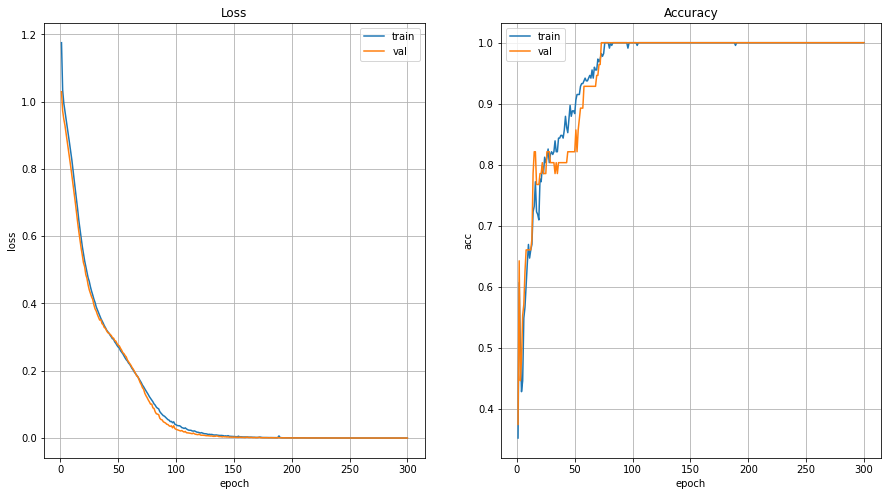

In [ ]:
plot_metrics(train_info1)

In [ ]:
print("Val accuracy =", train_info1.history['val_accuracy'][-1])

Val accuracy = 1.0


Эта сеть обучилась быстрее, чем многослойный перцептрон в прошлой лабе. Здесь достаточно 100 эпох для получения стопроцентной точности на тестовом датасете.

Посмотрим на скалярное поле

In [ ]:
h = 0.025

# TODO: оптимизировать вычисления (например посылать батчи с запросами)
grid = [model1.predict(np.array([[i, j]]), verbose=0).round(1)
        for i in np.arange(-1.2, 1.2 + h, h)
        for j in np.arange(-1.2, 1.2 + h, h)]

In [ ]:
x_vals = np.arange(-1.2, 1.2 + h, h)
y_vals = np.arange(-1.2, 1.2 + h, h)

xx, yy = np.meshgrid(x_vals, y_vals)

In [ ]:
colors = np.array(grid).reshape((len(grid), 3))
colors.shape


(9409, 3)

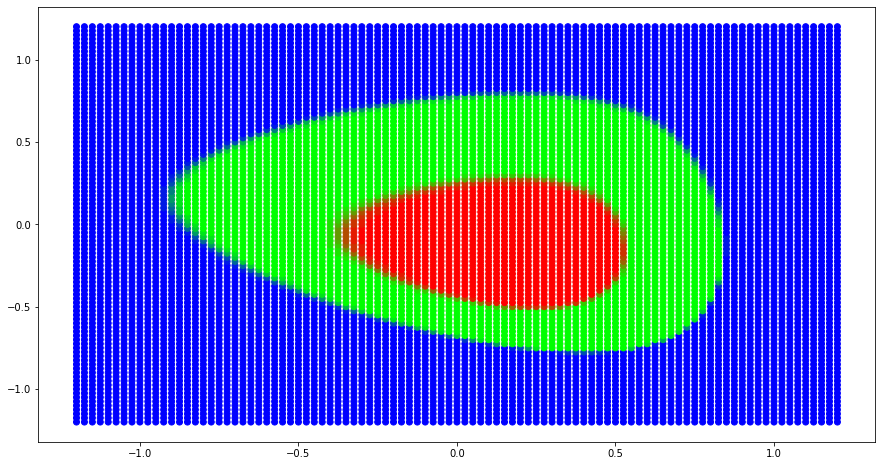

In [ ]:
plt.figure(figsize=(15, 8))

plt.scatter(xx, yy, c=colors)

plt.show()

Скалярное поле совпадает с первоначальным расположением эллипсов

### Задание 2

Пробуем использовать генеративный вариант RBF сети для предсказания значения функции (из прошлой лабы)

Сгенерим датасет

In [ ]:
def fun(t):
    return np.sin(-2 * t**2 + 7*t)

range_t = (0, 3.5)
h = 0.01

In [ ]:
t = np.linspace(range_t[0], range_t[1], int((range_t[1] - range_t[0]) / h))
x = fun(t)

Поделим на трейн и вал

In [ ]:
train_len = int(t.shape[0] * 0.9)

t_train = t[:train_len]
t_val = t[train_len:]

x_train = x[:train_len]
x_val = x[train_len:]

In [ ]:
t_train = np.expand_dims(t_train, 1)
t_val = np.expand_dims(t_val, 1)

In [ ]:
t_train.shape, t_val.shape

((315, 1), (35, 1))

Подготовим модель. Будем использовать генеративный RBF слой и линейный. Генеративный RBF нужно написать самому

In [ ]:
class RBF_gen(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(RBF_gen, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mu = self.add_weight(
            name='mu',
            shape=(input_shape[1], self.output_dim),
            initializer='uniform',
            trainable=True,
        )

        self.sigma = self.add_weight(
            name='sigma',
            shape=(self.output_dim, ),
            initializer='uniform',
            trainable=True,
        )

        self.sw = self.add_weight(
            name='sw',
            shape=(self.output_dim, ),
            initializer='uniform',
            trainable=True,
        )

        super(RBF_gen, self).build(input_shape)

    def call(self, inputs):
        diff = back.expand_dims(inputs) - self.mu
        output = back.exp(back.sum(diff**2, axis=1) * self.sigma)
        output = output * self.sw
        return output

Сделаем саму сеть

In [ ]:
model2 = keras.Sequential([
    RBF_gen(input_dim=1, output_dim=64),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1),
])

Скомпилируем ее и обучим

In [ ]:
model2.compile(
    loss='mse',
    optimizer='Adam',
    metrics=tf.keras.metrics.RootMeanSquaredError(),
)

In [ ]:
train_info2 = model2.fit(
    t_train,
    x_train,
    batch_size=4,
    epochs=500,
    validation_data=(t_val, x_val),
    verbose=0
)


Посмотрим на лосс и метрики

In [ ]:
def plot_metrics2(train_info):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    loss_history = train_info.history['loss']
    val_loss_history = train_info.history['val_loss']
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(range(1, len(loss_history) + 1), loss_history, label='train')
    plt.plot(range(1, len(loss_history) + 1), val_loss_history, label='val')
    plt.grid()
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    acc_history = train_info.history['root_mean_squared_error']
    val_acc_history = train_info.history['val_root_mean_squared_error']
    plt.xlabel('epoch')
    plt.ylabel('RMSE')
    plt.plot(range(1, len(acc_history) + 1), acc_history, label='train')
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label='val')
    plt.grid()
    plt.legend()
    plt.title('RMSE')

    plt.show()

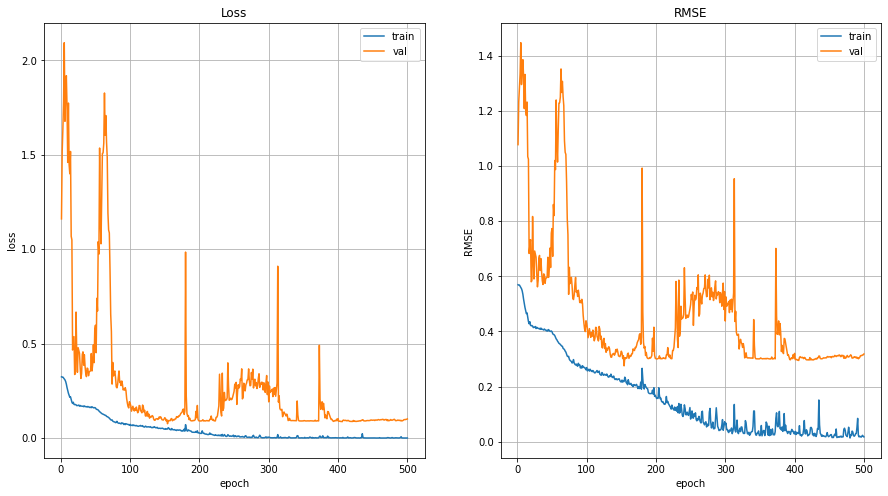

In [ ]:
plot_metrics2(train_info2)

In [ ]:
print("Val RMSE =", train_info2.history['val_root_mean_squared_error'][-1])

Val RMSE = 0.31839242577552795


Посмотрим на результаты на трейне

In [ ]:
def plot_results(model, t, fun):
    plt.figure(figsize=(15, 8))

    plt.plot(t, fun(t), label='true')
    plt.plot(t, model.predict(t, verbose=0), label='pred')

    plt.grid()
    plt.legend()
    plt.show()

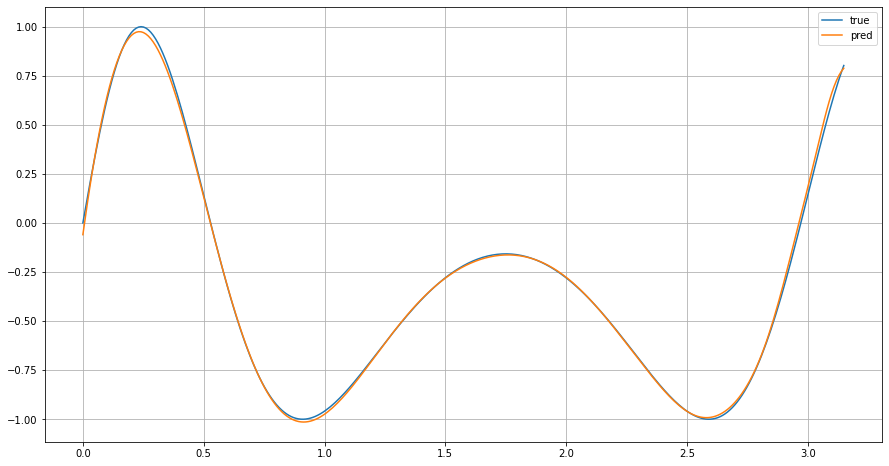

In [ ]:
plot_results(model2, t_train, fun)

И на вале

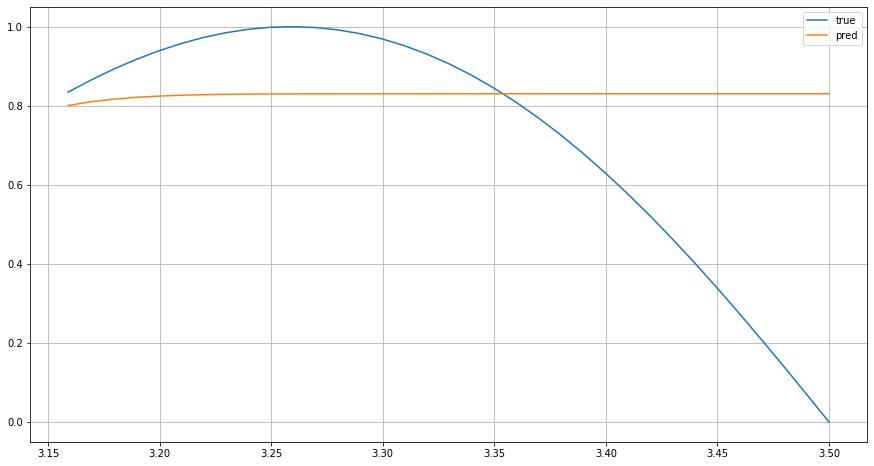

In [ ]:
plot_results(model2, t_val, fun)

In [ ]:
t_val_fl = t_val.flatten()
rmse_val = np.sqrt(np.mean((model2.predict(t_val, verbose=0).flatten() - fun(t_val_fl))**2))

print("RMSE =", rmse_val)

RMSE = 0.3183924146954445


## Вывод

В данной работе я познакомился с нейросетями с радиальными базисными элементами. Использование RBF-слоев позволяет отказаться от сигмоиды в пользу другой нелинейной функции с обучаемыми параметрами.

Я решил две задачи - задачу классификации линейно неразделимых классов (с использованием RBF слоя) и задачу регрессии (с использованием генеративного RBF слоя).

Результаты, на удивление, оказались лучше, чем у многослойного перцептрона - мы быстрее получили точность = 1 на классификации эллипсов и получили меньший RMSE во второй задаче (0.3 против 0.55). Хотя эта модель тоже не поняла, что нужно закруглить валидационную часть